In [2]:
import pandas as pd
import ast
import numpy as np

In [90]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [3]:
post_with_topic = pd.read_csv("../topic-modeling/data/positive_topic_dist.csv")
print(post_with_topic.columns)
post_with_topic["Topic Distribution"] = post_with_topic["Topic Distribution"].apply(lambda x: ast.literal_eval(x))
post_with_topic.head()

Index(['Unnamed: 0', 'author', 'subreddit_id', 'selftext', 'title', 'id', 'created_utc', 'Topic Distribution', 'most_probable_topic'], dtype='object')


,Unnamed: 0,author,subreddit_id,selftext,title,id,created_utc,Topic Distribution,most_probable_topic
0,0,-CreamyPie-,t5_o3plh,"Hello! Im 11 and Im a boy self recovering from anorexia. If you never saw my last post, I said on friday, ""Fear Food Friday"" I was going to have sweet scary cereal. Guess what it was? Froot Loops! I had me a bowl and it was pretty simple. 9/10. Pretty easy, I ate in my room in peace while watching youtube, and then I ate a banana after. I think I might buy another cereal. Theres so many types now lol. But yea, it was basic, It felt normal, Just ate and watched a video and sat down. Fe...",Fear Food Friday!! So far its successful,gbj0rh,1588343070,"[0.003704930553153588, 0.0008734280746749083, 0.0027177668338180384, 0.048346758641879616, 0.007509378074348145, 0.1357362532546351, 0.017228765520522566, 0.014247114805046765, 0.027907570015390147, 0.018457796864655564, 0.02507237026348541, 0.0031206368517028515, 0.14498486897396912, 0.00382996859058736, 0.0020321719710924596, 0.34519891047848955, 0.002129552182466121, 0.15361063905711517, 0.03963310469684806, 0.003658014296119375]",15
1,0,-CreamyPie-,t5_o3plh,"Alright so Its wednesday the day im typing this, its almost fear food friday, Im 11 and Im a boy in self recovery from anorexia. So for fear food friday I bought a box of.... Froot Loops!!! So on friday morning,Im going to pour myself a cold bowl of froot loops in the morning. Of course Im going to have fear foods on other days but not only on friday, But i figured friday is almost here so its a perfect time. Hopefully when the time comes I can do it. Motivation in the comments please...",Fear Food Friday is almost here.,gagddu,1588190127,"[0.003704930553153588, 0.0008734280746749083, 0.018564638615800884, 0.03249988685989677, 0.03920312163831384, 0.0089612789987723, 0.001381893738539719, 0.04594085836901246, 0.20222315961720147, 0.0026109250826727194, 0.009225498481502562, 0.0031206368517028515, 0.08159738184603774, 0.019676840372570205, 0.049572787317041, 0.29765829513254105, 0.002129552182466121, 0.16945751083909802, 0.007939361132882367, 0.003658014296119375]",15
2,0,-CreamyPie-,t5_o3plh,"Im 11, Im a boy, you've probably seen my other post, Im in self recovery. So I was eating lunch, and was some refried beans and a tortilla. I made myself a little burrito. Munched on that. Then I was bored and it was sunny outside so I decided to make a smoothie. I looked in my fridge and got some almond milk. I was thinking of making a strawberry banana smoothie but decided on only banana. So I grabbed a banana, 1 cup of almond milk, Blend. Came back to my room with my drink and tasted i...",Smoothie!!,g7xk05,1587836033,"[0.019866626213482064, 0.01698953077244474, 0.018863567145709772, 0.01692116257158796, 0.023732333095990463, 0.04130965131041252, 0.0014041450450316421, 0.030578561124446235, 0.012254900063413225, 0.0026529662994622186, 0.04157812526548563, 0.003170885467135907, 0.3888500018250573, 0.019993677618236703, 0.0020648940828670286, 0.286349161802521, 0.0021638423141752856, 0.027267773715095645, 0.024169239758384333, 0.01981895450906025]",12
3,1,194569324,t5_s5o7i,"Just want to get this off my chest because I don't know who else to tell. &amp;#x200B; I'm in virtual treatment and my treatment team thinks I'm doing great but I'm just lying my ass off about everything. They want to discharge me in two weeks or so after I've been in treatment for months. I know I'm not ready to leave treatment because I've already majorly relapsed since everything went virtual, but I'm also desperate and relieved to have a discharge date so I can go back to restricting w...","Hardcore restricting, close to being discharged from treatment, lying to my entire treatment team.",g3255g,1587130632,"[0.002993392052432115, 0.000705684659831887, 0.002195814880737728, 0.026258225798200266, 0.10849480368507837, 0.032847153188110864, 0.0011164985888141741, 0.21636616111866294, 0.06095822720315747, 0.014912944155737845, 0.00745372509

In [9]:
topic_list = pd.read_csv("../topic-modeling/data/analysis/topic_label_20.txt", delimiter="_", 
                         header = None, names = ["index", "topic_desc", "top_words"])
topic_list

,index,topic_desc,top_words
0,0,eatingBehavior (good),purging binge purge binging stop bulimia b/p day cycle bad
1,1,bodyParts (good),xNUMb hair would teeth dentist make mouth abs use email
2,2,family (good),mom family fat dad sister said parents told comments always
3,3,feeling (moderate),like feel even want know much get hate fucking never
4,4,work (bad),work get want time going need life back job hard
5,5,feeling (moderate),like feel really also know lot think still idk maybe
6,6,groceryShopping (moderate),food mad buy money cookies store candy buying kitchen fucking
7,7,feeling (moderate),know really get want eating think help tell disorder also
8,8,eat(good),eat eating food feel like meal even day hungry want
9,9,community (moderate),people post group recovery made diet disordered certain looking posts


In [10]:
post_with_topic["most_probable_topic"] = post_with_topic["Topic Distribution"].apply(lambda x: np.array(x).argmax())
post_with_topic["most_probable_topic"].value_counts()

3     497
7     357
8     337
15    313
10    225
17    218
4     140
18    135
5     119
11     77
12     71
19     65
0      58
13     50
14     37
9      36
6      31
16     30
2      30
1      14
Name: most_probable_topic, dtype: int64

In [12]:
trigger_extraction_result = pd.read_csv("./results/trigger_extraction_result_1682559339.705567.csv", keep_default_na = False)
for i in range(3):
    trigger_extraction_result[f"trigger_{i}"] = trigger_extraction_result[f"trigger_{i}"].apply(lambda x: ast.literal_eval(x) if x.startswith("[") else (None if x == "" else [x]))
    #print(trigger_extraction_result[f"trigger_{i}"].explode().value_counts(dropna=False))
    

In [13]:
trigger_extraction_result = trigger_extraction_result.merge(post_with_topic[["id","most_probable_topic"]], on="id", how="left")

In [14]:
trigger_extraction_result["most_probable_topic"].value_counts(dropna=False)

NaN     294
3.0       2
7.0       1
17.0      1
0.0       1
15.0      1
Name: most_probable_topic, dtype: int64

In [21]:
trigger_extraction_result["most_probable_topic_desc"] = trigger_extraction_result["most_probable_topic"].apply(lambda x: topic_list[x])

In [24]:
def most_common(x):
    top_5 = x.explode().value_counts(dropna=False)[:5]
    return [(x, c) for x, c in zip(top_5.index, top_5)]
trigger_extraction_result.groupby(["most_probable_topic"]).agg({
    "most_probable_topic_desc": ["first"],
    "trigger_0": [most_common],
    "trigger_1": [most_common],
    "trigger_2": [most_common]
})

,most_probable_topic_desc,trigger_0,trigger_1,trigger_2
,first,most_common,most_common,most_common
most_probable_topic,,,,
0,NUM treatment get work need year time therapist last back,"[(None, 16), (fear of failure, 1), (loss of father, boyfriend, job, school, and health issues, 1), (PTSD, 1), (nutritionist left, 1)]","[(None, 16), (being told her athletic body wasn't feminine, 1), (father, 1), (watching old colleagues now drop, 1), (two deaths of former colleagues over the weekend, 1)]","[(None, 14), (obsession with vanity and physique, 1), (problems with immunity, 1), (nutritionist leaving without addressing issues, financial strain, pressure from friends and personal issues, 1), (watching old colleagues now drop, 1)]"
1,eat food eating day meal hungry like meals calories binge,"[(None, 14), (scared to gain weight, 1), (poor fitting immediate denture, 1), (physical and emotional issues, 1), (Ate more than usual at a social gathering, 1)]","[(None, 14), (eating more than usual, 2), (found an old corset, 1), (binge behavior, 1), (weight gain, 1)]","[(None, 14), (scared to gain weight, 1), (fear of health impacts, 1), (binge behavior, 1), (cravings, 1)]"
2,life recovery people body self nNUM things would every love,"[(None, 11), (anxiety, 1), (lack of control, 1), (supply chain, 1), (grocery stores, 1)]","[(None, 11), (feeling like a failure, 2), (anxiety around depraving oneself, 1), (double tracking calories, 1), (feeling fat and hot, 1)]","[(None, 14), (new antipsychotic medication, 1), (overtracking calories, 1), (pandemic, 1), (income changes, 1)]"
3,look body like weight fat hate see skinny people always,"[(None, 11), (Adderall, 1), (fear of waking up mid-procedure, 1), (difficulty with fasting of drinks, 1), (only eating one meal per day, 1)]","[(None, 11), (constipation, 2), (blood glucose levels dropping and cortisol rising, 2), (doctor's insensitivity to the seriousness of her symptoms, 1), (lack of hunger, 1)]","[(None, 12), (constipation, 2), (severe PTSD, 1), (exercising and purging, 1), (GI specialist's attitude and inappropriate behavior/actions, 1)]"
4,NUM eat ate chocolate foods sugar cream food cake one,"[(None, 11), (stressful and traumatic experiences last Autumn, 1), (roommate's comment about olive oil, 1), (her mom refusing surgery for cancer because she thinks it will make her gain weight, 1), (my biological mother told me that she thought I was disgustingly skinny, 1)]","[(None, 10), (stressful and traumatic experience in Autumn, 1), (roommate said olive oil is healthy and good for you, made me feel paranoid and like my roommate wants me to be fat., 1), (older folks in the neighborhood who are bored, 1), (foto/gif where someone is very thin, 1)]","[(None, 12), (stressful and traumatic events in last autumn, 1), (roommate saying olive oil is healthy calories, 1), (mother commenting on weight gain, 1), (my biological mother, 1)]"
5,NUM weight gain back eating months lose lost still body,"[(None, 16), (wanting to be skinny, 1), (finding old clothes that are now too big, 1), (hate being anything other than a Small, ever, 1), (being terrible at ED life and gaining most of the weight back, 1)]","[(None, 16), (put on bikini, 1), (gaining weight, 1), (existing clothes don‚Äôt fit, 1), (sizing chart showed true weight, 1)]","[(None, 14), (put on a bikini, 1), (my disordered mind is like ‚Äúyou‚Äôre fat and he knows‚Äù, 1), (COVID isolation and lifestyle change, 1), (need to purchase new clothes, 1)]"
6,like know feel want really even eating get think never,"[(None, 11), (mom‚Äôs text, 1), (gender dysphoria, 1), (financial concerns, 1), (the termination of outpatient dietician for non-compliance, 1)]","[(None, 11), (mom mentioned sending to residential program, 1), (slow work day, 1), (Termination of new outpatient dietician after 2 sessions, 1), (Trouble getting a counselor, due to insurance and financial issues, 1)]","[(None, 14), (seeing text from mom, 1), (Parents asking her to cut her work hours and not stay h

In [9]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

## Create input file based on topic modeling

In [20]:
full_narrative_df = pd.read_csv("../narrative_detection/annotated_narrative_posts_by_trained_classification.csv")
narrative_with_topic_model = full_narrative_df.merge(post_with_topic[["id","most_probable_topic"]], on="id", how="inner")
print(len(narrative_with_topic_model))
print(narrative_with_topic_model.columns)


2839
Index(['Unnamed: 0', 'selected_for_experiment', 'subreddit', 'selftext', 'author_fullname', 'title', 'score', 'link_flair_css_class', 'link_flair_text', 'author_flair_type', 'over_18', 'author_flair_text', 'subreddit_id', 'id', 'is_self', 'author', 'author_flair_css_class', 'permalink', 'url', 'created_utc', 'num_words', 'narrative_positive', 'narrative_negative', 'narrative_uncertain', 'narrative_label', 'predicted_narrative_label', 'most_probable_topic'], dtype='object')


In [21]:
np.random.seed(20)
experiment_index = []
few_shot_index = []
for topic_i in range(len(topic_list)):
    print(f"Topic {topic_i}")
    topic_all_indexes = narrative_with_topic_model[narrative_with_topic_model["most_probable_topic"] == topic_i].index
    sample_size = min(11, len(topic_all_indexes))
    selected_indexes = np.random.choice(topic_all_indexes, sample_size, replace = False)
    experiment_index.extend(selected_indexes[1:])
    few_shot_index.append(selected_indexes[0])

Topic 0
Topic 1
Topic 2
Topic 3
Topic 4
Topic 5
Topic 6
Topic 7
Topic 8
Topic 9
Topic 10
Topic 11
Topic 12
Topic 13
Topic 14
Topic 15
Topic 16
Topic 17
Topic 18
Topic 19


In [22]:
narrative_with_topic_model.loc[experiment_index,"selected_for_experiment"] = 1
narrative_with_topic_model.loc[few_shot_index,"selected_for_example"] = 1

In [23]:
narrative_with_topic_model["selected_for_experiment"].value_counts(dropna=False)

NaN    2623
1.0     216
Name: selected_for_experiment, dtype: int64

In [24]:
#narrative_with_topic_model.to_csv("../narrative_detection/narrative_post_with_topic_model_20.csv", index=False)

In [10]:
narrative_with_topic_model = pd.read_csv("../narrative_detection/narrative_post_with_topic_model_20.csv")
narrative_with_topic_model_example = narrative_with_topic_model[narrative_with_topic_model["selected_for_example"] == 1]
narrative_with_topic_model_example[["id", "most_probable_topic","selftext", "num_words", "subreddit"]].sort_values("num_words").to_csv("./trigger_extraction_topic_examples.csv", index=False)
                                         

## Analyze results of trigger extraction on topic-based samples

In [15]:
trigger_extraction_result = pd.read_csv("./results/experiment_trigger_extraction_result_500_from_topic_model_zero_shot.csv", keep_default_na = False)
print(len(trigger_extraction_result))
for i in range(3):
    trigger_extraction_result[f"trigger_{i}"] = trigger_extraction_result[f"trigger_{i}"].apply(lambda x: ast.literal_eval(x) if x.startswith("[") else (None if x == "" else [x]))

350


In [16]:
trigger_extraction_result["has_trigger_2"].value_counts()

yes    207
no     136
         7
Name: has_trigger_2, dtype: int64

In [17]:
def most_common(x):
    top_5 = x.explode().value_counts(dropna=False)[:5]
    return [(x, c) for x, c in zip(top_5.index, top_5)]
trigger_extraction_result.groupby(["most_probable_topic"]).agg({
    "trigger_0": [most_common],
    "trigger_1": [most_common],
    "trigger_2": [most_common],
})

,trigger_0,trigger_1,trigger_2
,most_common,most_common,most_common
most_probable_topic,,,
0,"[(None, 16), (fear of failure, 1), (loss of father, boyfriend, job, school, and health issues, 1), (PTSD, 1), (nutritionist left, 1)]","[(None, 16), (being told her athletic body wasn't feminine, 1), (father, 1), (watching old colleagues now drop, 1), (two deaths of former colleagues over the weekend, 1)]","[(None, 14), (obsession with vanity and physique, 1), (problems with immunity, 1), (nutritionist leaving without addressing issues, financial strain, pressure from friends and personal issues, 1), (watching old colleagues now drop, 1)]"
1,"[(None, 14), (scared to gain weight, 1), (poor fitting immediate denture, 1), (physical and emotional issues, 1), (Ate more than usual at a social gathering, 1)]","[(None, 14), (eating more than usual, 2), (found an old corset, 1), (binge behavior, 1), (weight gain, 1)]","[(None, 14), (scared to gain weight, 1), (fear of health impacts, 1), (binge behavior, 1), (cravings, 1)]"
2,"[(None, 11), (anxiety, 1), (lack of control, 1), (supply chain, 1), (grocery stores, 1)]","[(None, 11), (feeling like a failure, 2), (anxiety around depraving oneself, 1), (double tracking calories, 1), (feeling fat and hot, 1)]","[(None, 14), (new antipsychotic medication, 1), (overtracking calories, 1), (pandemic, 1), (income changes, 1)]"
3,"[(None, 11), (Adderall, 1), (fear of waking up mid-procedure, 1), (difficulty with fasting of drinks, 1), (only eating one meal per day, 1)]","[(None, 11), (constipation, 2), (blood glucose levels dropping and cortisol rising, 2), (doctor's insensitivity to the seriousness of her symptoms, 1), (lack of hunger, 1)]","[(None, 12), (constipation, 2), (severe PTSD, 1), (exercising and purging, 1), (GI specialist's attitude and inappropriate behavior/actions, 1)]"
4,"[(None, 11), (stressful and traumatic experiences last Autumn, 1), (roommate's comment about olive oil, 1), (her mom refusing surgery for cancer because she thinks it will make her gain weight, 1), (my biological mother told me that she thought I was disgustingly skinny, 1)]","[(None, 10), (stressful and traumatic experience in Autumn, 1), (roommate said olive oil is healthy and good for you, made me feel paranoid and like my roommate wants me to be fat., 1), (older folks in the neighborhood who are bored, 1), (foto/gif where someone is very thin, 1)]","[(None, 12), (stressful and traumatic events in last autumn, 1), (roommate saying olive oil is healthy calories, 1), (mother commenting on weight gain, 1), (my biological mother, 1)]"
5,"[(None, 16), (wanting to be skinny, 1), (finding old clothes that are now too big, 1), (hate being anything other than a Small, ever, 1), (being terrible at ED life and gaining most of the weight back, 1)]","[(None, 16), (put on bikini, 1), (gaining weight, 1), (existing clothes don‚Äôt fit, 1), (sizing chart showed true weight, 1)]","[(None, 14), (put on a bikini, 1), (my disordered mind is like ‚Äúyou‚Äôre fat and he knows‚Äù, 1), (COVID isolation and lifestyle change, 1), (need to purchase new clothes, 1)]"
6,"[(None, 11), (mom‚Äôs text, 1), (gender dysphoria, 1), (financial concerns, 1), (the termination of outpatient dietician for non-compliance, 1)]","[(None, 11), (mom mentioned sending to residential program, 1), (slow work day, 1), (Termination of new outpatient dietician after 2 sessions, 1), (Trouble getting a counselor, due to insurance and financial issues, 1)]","[(None, 14), (seeing text from mom, 1), (Parents asking her to cut her work hours and not stay home, 1), (job hunt, 1), (rejection emails, 1)]"
7,"[(None, 18), (relapse into ED, 1), (my dietician doesn‚Äôt believe I could possibly have extreme hunger as I am not underweight, 1), (family history of breast cancer and possible ovarian cancer, 1), (hasn‚Äôt had period since February, 1)]","[(None, 18), (relapse into my ED, 1), (my dietician doesn‚Äôt believe I could possibly have extreme hunger as I am not underweight, 1), 

# Evaluation of trigger extraction performance

In [24]:
ground_truth = pd.read_csv("./trigger_extraction_label.csv", keep_default_na=False)
ground_truth["has_trigger_label"] = ground_truth["has_trigger"].apply(lambda x: 1 if x == "yes" else 0)
print(ground_truth["has_trigger"].value_counts())
ground_truth["grouped_trigger_label"] = ground_truth.apply(lambda x: ", ".join([x["trigger_1"], x["trigger_2"]]) if x["trigger_2"] != "" else x["trigger_1"], axis=1)
ground_truth["grouped_trigger_type_label"] = ground_truth.apply(lambda x: ", ".join([x["trigger_1_type"], x["trigger_2_type"]]) if x["trigger_2_type"] != "" else x["trigger_1_type"], axis=1)
ground_truth.head()

yes    171
no      45
Name: has_trigger, dtype: int64


,subreddit,selftext,id,assigned to,has_trigger,trigger_1,trigger_1_type,trigger_2,trigger_2_type,notes,has_trigger_label,grouped_trigger_label,grouped_trigger_type_label
0,EDAnonymous,"It‚Äö√Ñ√¥s breaking me apart to read through these posts. I‚Äö√Ñ√¥ve mostly recovered and I‚Äö√Ñ√¥m WR, but reading what I used to put myself through was so eye opening and it‚Äö√Ñ√¥s scary to see how many reblogs/likes they would get. I contribute to a horrible community full of self destruction and I can‚Äö√Ñ√¥t help but feel a little triggered into this weird, like, feeling I need to prove myself again? For example I made a post that was something like &gt;! Blah blah HORRIFICALLY UNHEALTHY THING TO DO, if I eat __ calories per day I‚Äö√Ñ√¥ll reach my GW in 24 days !&lt; and I immediately thought, omg, I can? Maybe I could do better? And I don‚Äö√Ñ√¥t know what‚Äö√Ñ√¥s wrong with me! I haven‚Äö√Ñ√¥t relapsed in a long time and I don‚Äö√Ñ√¥t want to, but the feeling of guilt and seeing these posts is making me all confused and competitive and self depreciated. Ugh.",10eemqs,anthony,yes,Reading posts from reddit,external,,,,1,Reading posts from reddit,external
1,EDAnonymous,"I have BED and when I start restricting and my face is the first place people will notice. I have have naturally high and prominent cheekbones, which are ""trendy"" right now, and my mom and friends won't stop telling how ""pretty"" I look these days.\n \n Of couser thats nice to hear, the jokes about Bella hadid cheeks put my God complex through the roof!!\n But at the end of the day, I'll come back home, read another article on how ""heroin chic"" is back, write critiques about about how goddam harmful this thinking is to young women everywhere, while I skip yet again another meal. I am a hypocrite. And feel like I have no control over my own brain.\n \n I study social comunnications and sociology but can't help but hate myself for falling for the very phenomenomena I study. I know it's wrong, I know it's harmful, my body is giving me signs its starting to giving up on me these days.\n \n I feel guilty.",10ee8p5,anthony,yes,Getting compliments when they start restricting,external,Feeling hypocritical because they study these problems,internal,,1,"Getting compliments when they start restricting, Feeling hypocritical because they study these problems","external, internal"
2,EDAnonymous,"As a kid I always wanted to be taller. I figured I could eat more and weigh more but be slimmer. \n Now I want to be shorter. I would be happy being a normal weight if it was low bc I'm so small. Idk what's wrong with me but for years I've just wanted to look like a child. \n \n But, I do think I stunted my height a bit. With calculations I predicted I should be taller than my mum. She's quite tall but I'm just average height. \n \n Not to mention my boyfriend is only a little bit taller than me, but I wish there was more of a difference because I was smaller.",10e4an6,anthony,yes,"Unhappy with weight, wishes they were shorter",internal,,,,1,"Unhappy with weight, wishes they were shorter",internal
3,EDAnonymous,"Im so scared omg, i lie to my doctor saying im in recovery, while im obviously not. I lie because its the only way i'll ever be able to get adhd meds and i kinda have no choice... Next week my gp wants to do blood tests on me to ""prove"" that im in recovery, is there any way i could fake this or somehow make it seem that i eat normally? \n \n \n I TRULY have no choice, these adhd meds are so vital to my future that if i can't get them i'll have to start doing drugs instead to self medicate, so being found out is not an option\n \n Im at an obese bmi, i take multivitamins twice a day and iron supplements, nothing about me scream restrictive ED, Im just an idiot for being honest with my doctors...",10do1eh,anthony,no,,,,,,0,,
4,EDAnonymous,"So when I first started really leaning into my eating disorder I was around 230 pounds. I've lost about 55 pounds since then, and even now I alrea

In [25]:
zero_shot = pd.read_csv("./results/experiment_trigger_extraction_result_500_from_topic_model_zero_shot.csv", keep_default_na=False)
narrative_df = pd.read_csv("../narrative_detection/narrative_post_with_topic_model_20.csv")
narrative_df = narrative_df[narrative_df["selected_for_experiment"] == 1]
zero_shot = zero_shot.merge(narrative_df["id"], on="id", how="right")
print(len(zero_shot))
zero_shot.columns

216


Index(['Unnamed: 0', 'selected_for_experiment', 'subreddit', 'selftext', 'author_fullname', 'title', 'score', 'link_flair_css_class', 'link_flair_text', 'author_flair_type', 'over_18', 'author_flair_text', 'subreddit_id', 'id', 'is_self', 'author', 'author_flair_css_class', 'permalink', 'url', 'created_utc', 'num_words', 'narrative_positive', 'narrative_negative', 'narrative_uncertain', 'narrative_label', 'predicted_narrative_label', 'most_probable_topic', '1', 'duration_0', 'has_trigger_0', 'trigger_0', 'gender_0', 'age_0', 'trigger_type_0', 'perspective_0', 'duration_1', 'has_trigger_1', 'trigger_1', 'gender_1', 'age_1', 'trigger_type_1', 'perspective_1', 'duration_2', 'has_trigger_2', 'trigger_2', 'gender_2', 'age_2', 'trigger_type_2', 'perspective_2', 'index', 'selected_for_example'], dtype='object')

In [26]:
zero_shot["has_trigger_2"].value_counts(dropna=False)

yes    125
no      87
         4
Name: has_trigger_2, dtype: int64

In [27]:
zero_shot["has_trigger_predicted"] = zero_shot.apply(lambda x: 1 if "yes" in [x["has_trigger_0"].lower(), 
                                                                       x["has_trigger_1"].lower(), 
                                                                       x["has_trigger_2"].lower()
                                                                      ] else 0, axis=1)
zero_shot["has_trigger_predicted"].value_counts()
                                                                       

1    142
0     74
Name: has_trigger_predicted, dtype: int64

In [28]:
few_shot = pd.read_csv("./results/experiment_trigger_extraction_result_3_examples.csv", keep_default_na=False)
print(len(few_shot))
for i in range(3):
    print(few_shot[f"has_trigger_{i}"].value_counts(dropna=False))

216
no     113
yes     98
         5
Name: has_trigger_0, dtype: int64
no     110
yes    101
         5
Name: has_trigger_1, dtype: int64
no     112
yes     98
         6
Name: has_trigger_2, dtype: int64


In [29]:
few_shot["has_trigger_predicted"] = few_shot.apply(lambda x: 1 if "yes" in [x["has_trigger_0"].lower(), 
                                                                       x["has_trigger_1"].lower(), 
                                                                       x["has_trigger_2"].lower()
                                                                      ] else 0, axis=1)
few_shot["has_trigger_predicted"].value_counts()

1    119
0     97
Name: has_trigger_predicted, dtype: int64

In [30]:
few_shot_include_multiple = pd.read_csv("./results/experiment_trigger_extraction_result_3_examples_include_multiple_trigger.csv", keep_default_na=False)
print(len(few_shot_include_multiple))
for i in range(3):
    print(few_shot_include_multiple[f"has_trigger_{i}"].value_counts(dropna=False))

few_shot_include_multiple["has_trigger_predicted"] = few_shot_include_multiple.apply(lambda x: 1 if "yes" in [x["has_trigger_0"].lower(), 
                                                                       x["has_trigger_1"].lower(), 
                                                                       x["has_trigger_2"].lower()
                                                                      ] else 0, axis=1)
few_shot_include_multiple["has_trigger_predicted"].value_counts()

216
yes    112
no      99
         5
Name: has_trigger_0, dtype: int64
yes    118
no      95
         3
Name: has_trigger_1, dtype: int64
yes    119
no      94
         3
Name: has_trigger_2, dtype: int64


1    137
0     79
Name: has_trigger_predicted, dtype: int64

In [31]:
few_shot_1_include_multiple = pd.read_csv("./results/experiment_trigger_extraction_result_1_example_include_multiple_trigger.csv", keep_default_na=False)
print(len(few_shot_1_include_multiple))
for i in range(3):
    print(few_shot_1_include_multiple[f"has_trigger_{i}"].value_counts(dropna=False))
few_shot_1_include_multiple["has_trigger_predicted"] = few_shot_1_include_multiple.apply(lambda x: 1 if "yes" in [x["has_trigger_0"].lower(), 
                                                                       x["has_trigger_1"].lower(), 
                                                                       x["has_trigger_2"].lower()
                                                                      ] else 0, axis=1)
few_shot_1_include_multiple["has_trigger_predicted"].value_counts()

216
no     112
yes    101
         3
Name: has_trigger_0, dtype: int64
yes    111
no     100
         5
Name: has_trigger_1, dtype: int64
yes    106
no     105
         5
Name: has_trigger_2, dtype: int64


1    126
0     90
Name: has_trigger_predicted, dtype: int64

## Check extraction rate


In [3]:
from functools import reduce
columns_of_interest = ["id", "has_trigger_predicted", "trigger_0", "trigger_1", "trigger_2"]
all_methods = {
    "zero_shot": zero_shot[columns_of_interest],
    "few_shot_3": few_shot[columns_of_interest],
    "few_shot_3_include_multiple": few_shot_include_multiple[columns_of_interest],
    "few_shot_1_include_multiple": few_shot_1_include_multiple[columns_of_interest]
}
for key, df in all_methods.items():
    df.columns = ["id", f"has_trigger_predicted_{key}", f"trigger_0_{key}", f"trigger_1_{key}", f"trigger_2_{key}"]
    print(df.columns)

all_results = reduce(lambda x, y: x.merge(y,on="id"), all_methods.values())
all_results = ground_truth[["id", "selftext", "has_trigger_label", "grouped_trigger_label", "grouped_trigger_type_label"]].merge(all_results, on="id")
has_trigger_columns = [f"has_trigger_predicted_{key}" for key in all_methods.keys()]
all_results["trigger_score"] = all_results.apply(lambda x: sum(x[has_trigger_columns]), axis=1)
all_results["trigger_score"].value_counts()

NameError: name 'zero_shot' is not defined

In [33]:
all_results.to_csv("results/trigger_extraction_experiment_results.csv", index=False)

In [13]:
all_results = pd.read_csv("results/trigger_extraction_experiment_results.csv")

zero_shot: precision = 0.8380281690140845, recall = 0.695906432748538, f1 = 0.7603833865814696
few_shot_3: precision = 0.8487394957983193, recall = 0.5906432748538012, f1 = 0.6965517241379311
few_shot_3_include_multiple: precision = 0.8467153284671532, recall = 0.6783625730994152, f1 = 0.7532467532467532
few_shot_1_include_multiple: precision = 0.8650793650793651, recall = 0.6374269005847953, f1 = 0.734006734006734


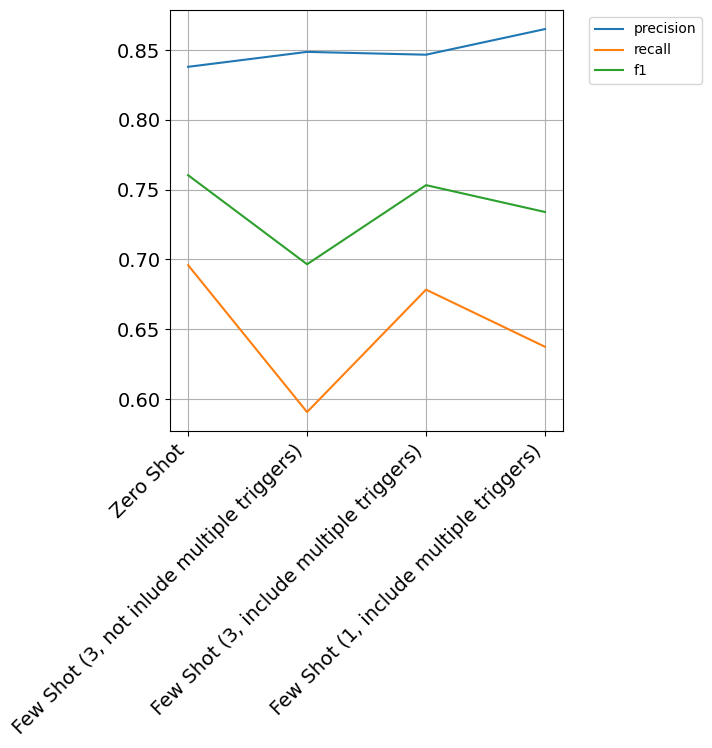

In [16]:
# Recall and Precision
from sklearn.metrics import precision_recall_fscore_support

trigger_extraction_rate_performance = {
    "precision": [],
    "recall": [],
    "f1": []
}

for method in all_methods:
    p, r, f, _ = precision_recall_fscore_support(all_results["has_trigger_label"], all_results[f"has_trigger_predicted_{method}"], average="binary")
    print(f"{method}: precision = {p}, recall = {r}, f1 = {f}")
    trigger_extraction_rate_performance["precision"].append(p)
    trigger_extraction_rate_performance["recall"].append(r)
    trigger_extraction_rate_performance["f1"].append(f)


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
all_methods_labels = ["Zero Shot", "Few Shot (3, not inlude multiple triggers)", "Few Shot (3, include multiple triggers)", "Few Shot (1, include multiple triggers)"]
for metric, value in trigger_extraction_rate_performance.items():
    ax.plot(all_methods_labels, value, label = metric)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig("Trigger extraction rate comparison.pdf", bbox_inches='tight')

In [48]:
!pip install nltk

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)


In [77]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import string
reference = ["Reading posts from reddit".lower().split(" ")]
candidate = ["['reading triggering posts']".lower().translate(str.maketrans('','',string.punctuation)).split(" ")]
print(reference)
print(candidate)
print('Individual 1-gram: %f' % corpus_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % corpus_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % corpus_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % corpus_bleu(reference, candidate, weights=(0, 0, 0, 1)))

[['reading', 'posts', 'from', 'reddit']]
[['reading', 'triggering', 'posts']]
Individual 1-gram: 0.000000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


In [73]:
!pip install rouge

In [80]:
from rouge import Rouge
ROUGE = Rouge()
ROUGE.get_scores(" ".join(candidate[0]), " ".join(reference[0]))[0]["rouge-1"]
def get_score(candidate: str, reference: str):
    score = ROUGE.get_scores(candidate, reference)[0]["rouge-1"]
    return score["r"], score["p"], score["f"]
    

In [84]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def process_response(x: str):
    x = x.lower().translate(str.maketrans('','',string.punctuation))
    return x
    

In [136]:
extracted_results = all_results.loc[(all_results["has_trigger_label"] == 1) & (all_results["trigger_score"] == 4)]
print(len(extracted_results))

extracted_results["grouped_trigger_label"] = extracted_results["grouped_trigger_label"].apply(process_response)
ret = []
error_count = 0
for row in range(len(extracted_results)):
    print(f"Row {row}")
    temp = {
    "id": all_results["id"][row],
    "selftext": all_results["selftext"][row],
    "grouped_trigger_label": all_results["grouped_trigger_label"][row]
    }
    for method in all_methods.keys():
        for i in range(3):
            candidate = process_response(all_results[f"trigger_{i}_{method}"][row])
            reference = all_results["grouped_trigger_label"][row]
            try:
                r, p, f = get_score(candidate, reference)
                temp[f"recall_{method}_{i}"] = r
                temp[f"precision_{method}_{i}"] = p
                temp[f"f1_{method}_{i}"] = f
            except Exception as e:
                #print(f"Human: {all_results['grouped_trigger_label'][row]}")
                #print(f"LLM: {all_results[f'trigger_{i}_{method}'][row]}")
                #print(e)
                error_count +=1
                temp[f"recall_{method}_{i}"] = None
                temp[f"precision_{method}_{i}"] = None
                temp[f"f1_{method}_{i}"] = None
    ret.append(temp)
print(error_count)

87
Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
606


/var/folders/fj/7t9sn4pn7t993nnng_9lyxtr0000gn/T/ipykernel_70758/931061301.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_results["grouped_trigger_label"] = extracted_results["grouped_trigger_label"].apply(process_response)


In [137]:
ret_df = pd.DataFrame(ret)
print(len(ret_df))

87


In [138]:
for method in all_methods.keys():
    print(method)
    ret_df[f"recall_{method}"] = ret_df.apply(lambda x: np.nanmax([x[f"recall_{method}_{i}"] for i in range(3)]), axis=1)
    ret_df[f"precision_{method}"] = ret_df.apply(lambda x: np.nanmax([x[f"precision_{method}_{i}"] for i in range(3)]), axis=1)
    ret_df[f"f1_{method}"] = ret_df.apply(lambda x: np.nanmax([x[f"f1_{method}_{i}"] for i in range(3)]), axis=1)
    print(ret_df[f"recall_{method}"].mean())
    print(ret_df[f"precision_{method}"].mean())
    print(ret_df[f"f1_{method}"].mean())

zero_shot
0.25796014124803174
0.19049168424168422
0.1915064493153471
few_shot_3
0.2641236910425506
0.22098063519632144
0.2199519839448537
few_shot_3_include_multiple
0.25568589305431416
0.1671191401191401
0.17982958624986717
few_shot_1_include_multiple
0.3157872737642475
0.1822897398439194
0.2018209628764514


/var/folders/fj/7t9sn4pn7t993nnng_9lyxtr0000gn/T/ipykernel_70758/2433236975.py:3: RuntimeWarning: All-NaN axis encountered
  ret_df[f"recall_{method}"] = ret_df.apply(lambda x: np.nanmax([x[f"recall_{method}_{i}"] for i in range(3)]), axis=1)
/var/folders/fj/7t9sn4pn7t993nnng_9lyxtr0000gn/T/ipykernel_70758/2433236975.py:4: RuntimeWarning: All-NaN axis encountered
  ret_df[f"precision_{method}"] = ret_df.apply(lambda x: np.nanmax([x[f"precision_{method}_{i}"] for i in range(3)]), axis=1)
/var/folders/fj/7t9sn4pn7t993nnng_9lyxtr0000gn/T/ipykernel_70758/2433236975.py:5: RuntimeWarning: All-NaN axis encountered
  ret_df[f"f1_{method}"] = ret_df.apply(lambda x: np.nanmax([x[f"f1_{method}_{i}"] for i in range(3)]), axis=1)
/var/folders/fj/7t9sn4pn7t993nnng_9lyxtr0000gn/T/ipykernel_70758/2433236975.py:3: RuntimeWarning: All-NaN axis encountered
  ret_df[f"recall_{method}"] = ret_df.apply(lambda x: np.nanmax([x[f"recall_{method}_{i}"] for i in range(3)]), axis=1)
/var/folders/fj/7t9sn4pn7t993n

In [139]:
ret_df.to_csv("trigger_extraction_accuracy_result.csv", index=False)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

ret_df = pd.read_csv("trigger_extraction_accuracy_result.csv")
all_methods = [
    "zero_shot",
    "few_shot_3",
    "few_shot_3_include_multiple",
    "few_shot_1_include_multiple"
]
all_methods_labels = ["Zero Shot", "Few Shot (3, not inlude multiple triggers)", "Few Shot (3, include multiple triggers)", "Few Shot (1, include multiple triggers)"]


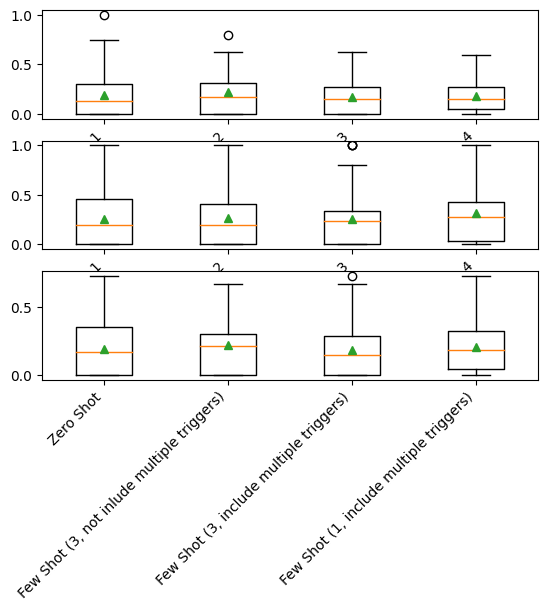

In [6]:
fig, ax = plt.subplots(3)
for i, metric in enumerate(["precision", "recall", "f1"]):
    ax[i].boxplot([ret_df[f"{metric}_{method}"].dropna() for method in all_methods],
              showmeans=True)
    plt.xticks([1, 2, 3, 4], all_methods_labels)
    plt.setp(ax[i].get_xticklabels(), rotation=45, horizontalalignment='right')


In [7]:
ret_df["recall_zero_shot"].median()

0.19375

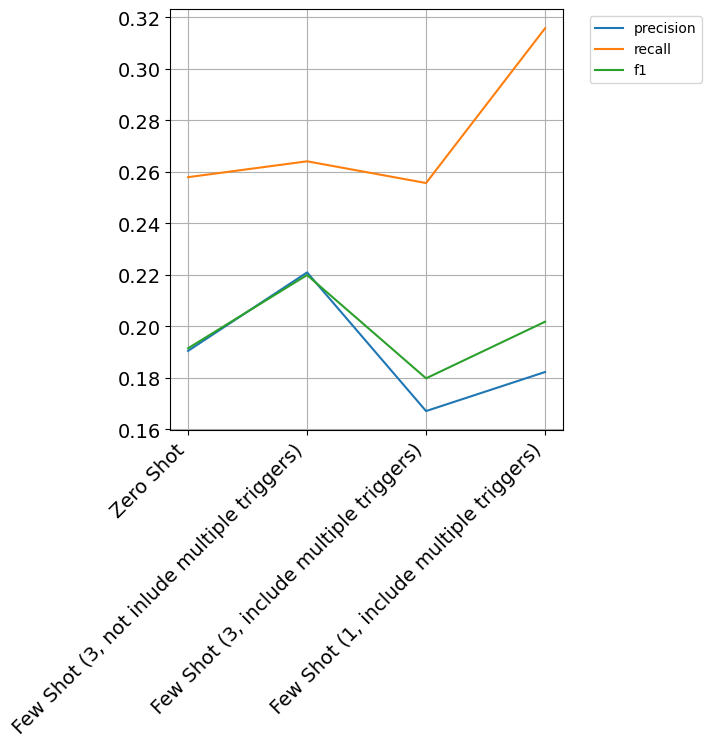

In [12]:
fig, ax = plt.subplots()
for metric in ["precision", "recall", "f1"]:
    ax.plot(all_methods_labels, [ret_df[f"{metric}_{method}"].mean() for method in all_methods], label = metric)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig("Trigger extraction accuracy performance.pdf", bbox_inches='tight')

In [17]:
ret_df.head()

,id,selftext,grouped_trigger_label,recall_zero_shot_0,precision_zero_shot_0,f1_zero_shot_0,recall_zero_shot_1,precision_zero_shot_1,f1_zero_shot_1,recall_zero_shot_2,...,f1_zero_shot,recall_few_shot_3,precision_few_shot_3,f1_few_shot_3,recall_few_shot_3_include_multiple,precision_few_shot_3_include_multiple,f1_few_shot_3_include_multiple,recall_few_shot_1_include_multiple,precision_few_shot_1_include_multiple,f1_few_shot_1_include_multiple
0,10eemqs,It‚Äö√Ñ√¥s breaking me apart to read through t...,Reading posts from reddit,0.250000,0.125000,0.166667,0.250000,0.1,0.142857,0.250000,...,0.166667,0.250000,0.166667,0.200000,0.250000,0.083333,0.125000,0.250000,0.090909,0.133333
1,10ee8p5,I have BED and when I start restricting and my...,Getting compliments when they start restrictin...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.083333,0.166667,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,10e4an6,As a kid I always wanted to be taller. I figur...,"Unhappy with weight, wishes they were shorter",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10do1eh,"Im so scared omg, i lie to my doctor saying im...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10dig38,So when I first started really leaning into my...,Having loose skin because of weight loss,0.142857,0.111111,0.125000,0.571429,1.0,0.727273,0.428571,...,0.727273,0.428571,0.600000,0.500000,0.285714,0.400000,0.333333,0.428571,0.500000,0.375000


In [20]:
full_ret_df = ret_df.merge(all_results, on=["id","selftext", "grouped_trigger_label"], how = "left")

In [21]:
len(full_ret_df)

87

In [ ]:
full_ret_df.to_csv("results/trigger_extraction_acc